In [14]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 180


In [2]:
# I load the datasets into a panda dataframe and stored them into a list.
def data_load():
    return [pd.read_csv("data_1_"+str(i)+".csv") for i in range(1,6)]

In [3]:
datalist=data_load()

In [4]:
for i in range(5):
    print(datalist[i].corr())

          x         y
x  1.000000  0.404952
y  0.404952  1.000000
          x         y
x  1.000000  0.630943
y  0.630943  1.000000
          x         y
x  1.000000 -0.321248
y -0.321248  1.000000
          x         y
x  1.000000  0.166117
y  0.166117  1.000000
          x         y
x  1.000000 -0.529694
y -0.529694  1.000000


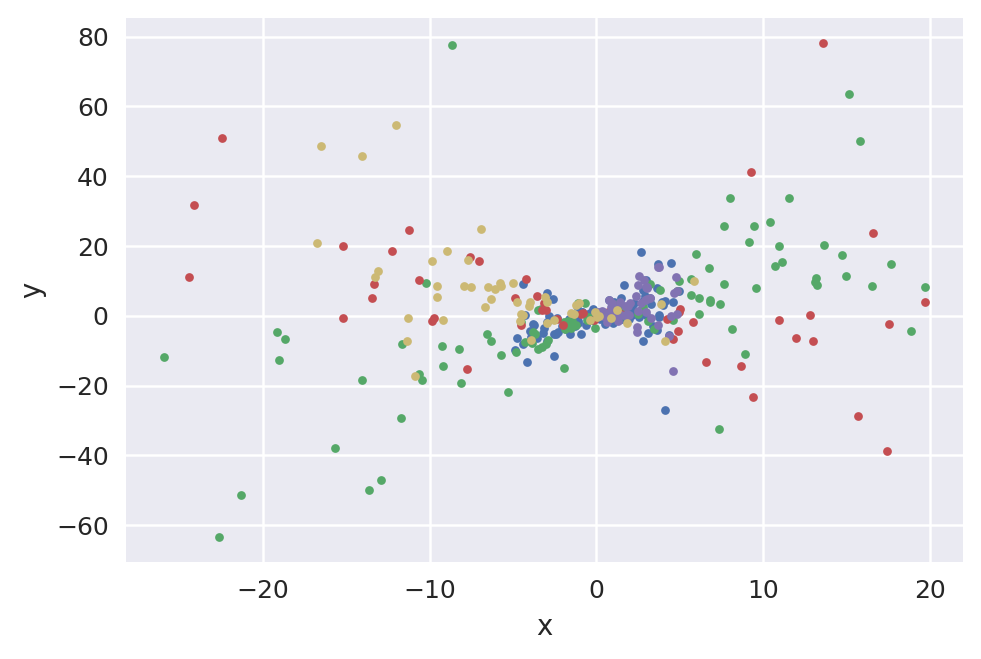

In [7]:
#Plotting all of the data at once to have a better understanding of the error distribution.
for i in range(5):
    plt.plot(datalist[i]['x'], datalist[i]['y'], '.')
    plt.xlabel('x')
    plt.ylabel('y')

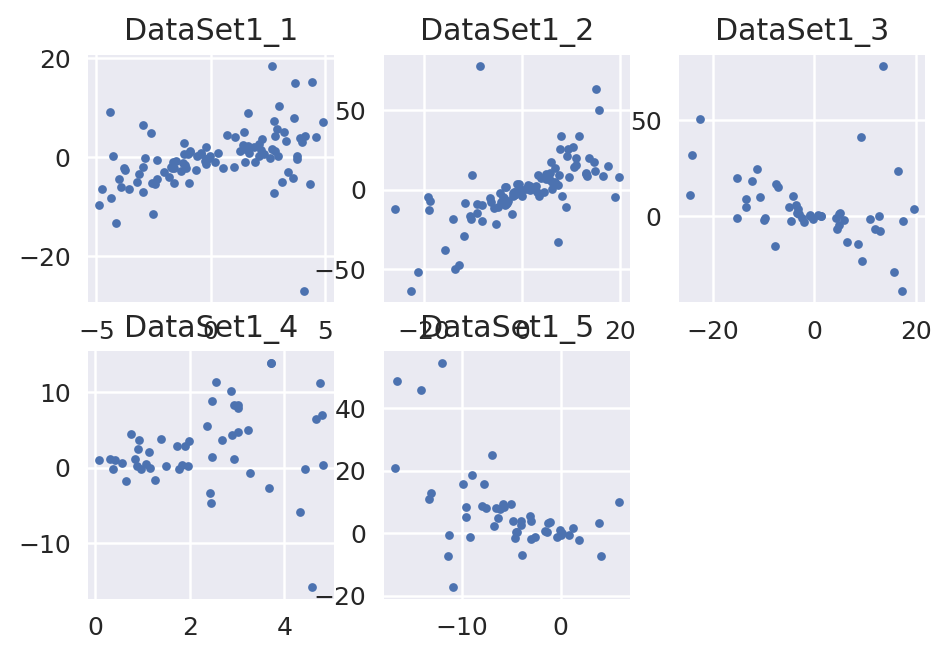

In [8]:
# We plot the data separately to understand the relation of x and y.
# Below is the plot of the five datasets.
for i in range(1,6):
    plt.subplot(2, 3, i)
    plt.title('DataSet1_'+str(i))
    plt.plot(datalist[i-1]['x'], datalist[i-1]['y'], '.')

In [9]:
# I used Sickit_learn to design and fit all of the models. 
# This effort includes designing a pipeline to use cross-validation and to search the best parameters to apply on data.
# We later fit using a GridSearch.
# The coefficient R^2 is  used in scoring.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from yellowbrick.regressor import ResidualsPlot

In [10]:
#performing cross validation using ShuffleSplit. We will later use this in our pipelines.
cv=model_selection.ShuffleSplit(n_splits=10, test_size=0.2) 

Three different models were compared. Models include:
    * OLS: Ordinary least squares Linear Regression
        This model minimizes the residual sum of squares between the observed responses in the dataset,
        and the responses predicted by the linear approximation.
        
    * Huber Regressor: Linear regression model that is robust to outliers.
        The Huber Regressor optimizes the squared loss for the samples where |(y - X'w) / sigma| < epsilon and 
        the absolute loss for the samples where |(y - X'w) / sigma| > epsilon, where w and sigma are parameters 
        to be optimized.
        
    * Elastic Net: Linear regression with combined L1 and L2 priors as regularizer.
        We control the convex combination of L1 and L2 using the l1_ratio parameter.
        Minimizing the objective function of:
        1 / (2 * n_samples) * ||y - Xw||^2_2
        + alpha * l1_ratio * ||w||_1
        + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

In [11]:
#OLS MODEL
OLS_pipe = Pipeline([
    #('scaler', RobustScaler()),
    ('LinearModel', LinearRegression())
    ])
OLS_param_grid={'LinearModel__normalize': [False,True]}

OLS_GridResult = model_selection.GridSearchCV(OLS_pipe, 
                                          param_grid=OLS_param_grid, 
                                          cv=cv, #Random permutation cross-validator
                                          scoring='neg_mean_absolute_error'
                                         )

In [12]:
#SGD MODEL
SGD_pipe = Pipeline([
    #('scaler', RobustScaler()),
    ('LinearModel', SGDRegressor())
    ])
SGD_param_grid={'LinearModel__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], #The loss function to be used
               'LinearModel__alpha': [0.01,0.001,0.0001, 0.00001], #Constant that multiplies the regularization term
               'LinearModel__penalty': ['none', 'l2', 'l1', 'elasticnet'], #The penalty (aka regularization term) to be used.
               #'LinearModel__max_iter': [5], #Max number of iteration
                'LinearModel__l1_ratio': np.arange(0, 1.01, 0.05), #The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1. Defaults to 0.15.
                'LinearModel__learning_rate': ['constant','optimal','invscaling'] 
               }

SGD_GridResult = model_selection.GridSearchCV(SGD_pipe, 
                                          param_grid=SGD_param_grid, 
                                          cv=cv, #Random permutation cross-validator
                                          n_jobs=-1,
                                          scoring='neg_mean_absolute_error'
                                         )

In [21]:
#Huber Model
Huber_pipe = Pipeline([
    #('scaler', RobustScaler()),
    ('LinearModel', HuberRegressor())
    ])
Huber_param_grid={'LinearModel__alpha': [0.01,0.001,0.0001, 0.00001]} #Regularization strength, Gridsearch will find the best 
                                                                                #parameter and will use it to train the model.

Huber_GridResult = model_selection.GridSearchCV(Huber_pipe, 
                                          param_grid=Huber_param_grid, 
                                          cv=cv, #Random permutation cross-validator
                                         )

In [23]:
#ElasticNet Model
Elastic_pipe = Pipeline([
    #('scaler', RobustScaler()),
    ('LinearModel', ElasticNet()),
    ])
Elastic_param_grid={'LinearModel__normalize': [False,True],
                  'LinearModel__l1_ratio': np.arange(0, 1.01, 0.05),
                  'LinearModel__alpha': np.arange(0, 1.01, 0.05)} #Regularization strength, Gridsearch will find the best 
                                                                                #parameter and will use it to train the model.

Elastic_GridResult = model_selection.GridSearchCV(Elastic_pipe, 
                                          param_grid=Elastic_param_grid, 
                                          cv=cv, #Random permutation cross-validator
                                         )

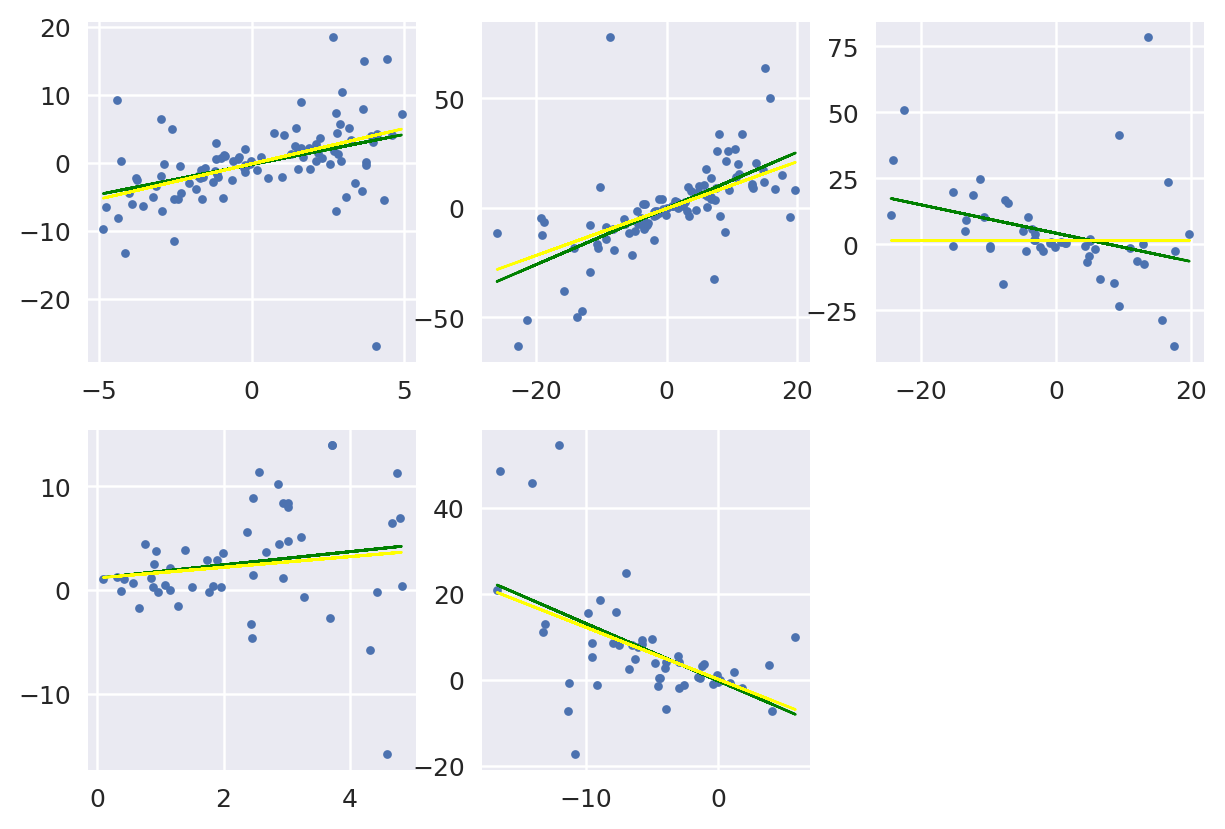

In [28]:
# Plotting regression line on the data sets to visualize how our model is performing. 
# Green line demonstrate regression line obtained by OLS model and the Yellow line indicates our SGD using best parameters.
for i in range(1,6):
    plt.subplot(2, 3, i)
    x=datalist[i-1]['x'].values.reshape(-1, 1)
    y=datalist[i-1]['y'].values.reshape(-1, 1)
    plt.plot(x, y, '.')
    plt.plot(x,OLS_GridResult.fit(x, y).predict(x), color='green',linewidth=1)
    plt.plot(x,SGD_GridResult.fit(x, y).predict(x), color='yellow',linewidth=1)

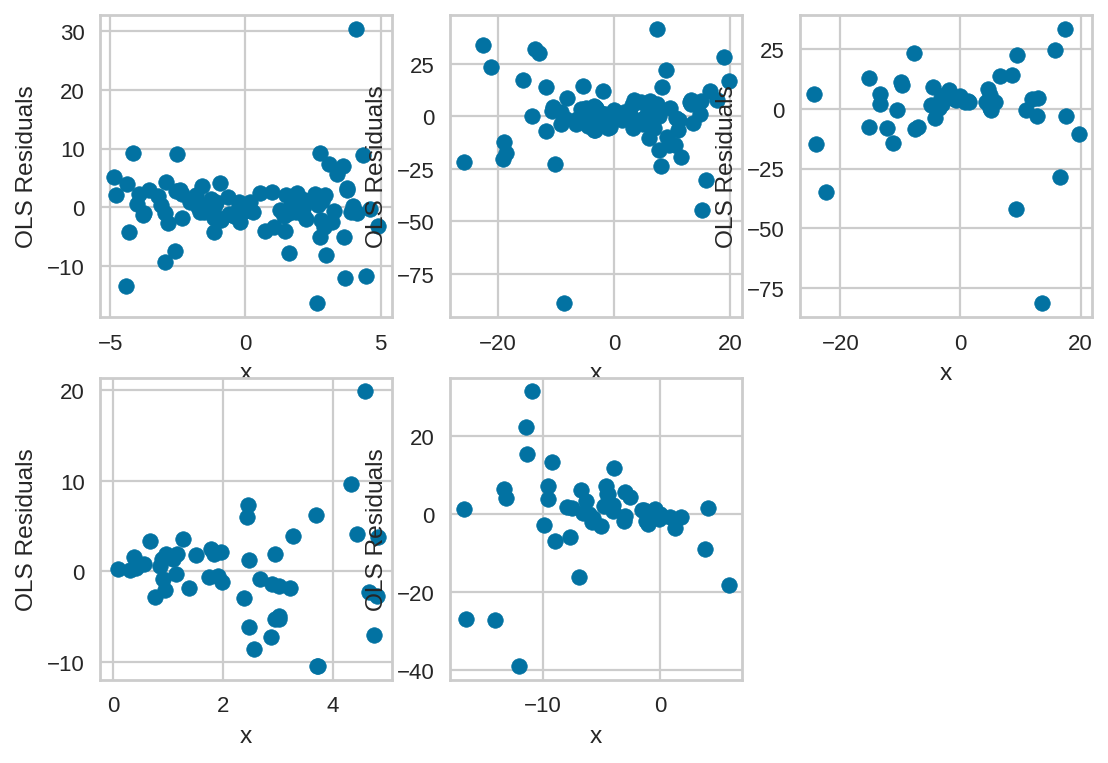

In [50]:
# We plot the residuals using our OLS model to see how well our model is fitting the data.
for i in range(1,6):
    plt.subplot(2, 3, i)
    x=datalist[i-1]['x'].values.reshape(-1, 1)
    y=datalist[i-1]['y'].values.reshape(-1, 1)
    plt.scatter(x,OLS_GridResult.fit(x, y).predict(x)-y)
    plt.hlines(y=0,xmin=0,xmax=0)
    plt.ylabel('OLS Residuals')
    plt.xlabel('x')

In [29]:
# We now try different models on our data to compare their accuracy. the results will be stored in a dataframe.
data_MAE=pd.DataFrame([])
for i in range(5):
    x=datalist[i]['x'].values.reshape(-1, 1)
    y=datalist[i]['y'].values.reshape(-1, 1)
    #Fitting the models 
    for model in [('OLS', OLS_GridResult), ('SGD', SGD_GridResult)]:
    #[('OLS', OLS_GridResult),('Huber',Huber_GridResult),('Elastic',Elastic_GridResult),('Lasso',Lasso_GridResult) ]:
        fitted=model[1].fit(x, y)
        score=abs(model[1].score(x,y))
        coef=model[1].best_estimator_.steps[0][1].coef_.item(0)
        Best_parameter=model[1].best_params_
        Intercept=model[1].best_estimator_.steps[0][1].intercept_.item(0)
        data_MAE = data_MAE.append(pd.DataFrame({'DataSet': 'Dataset1_'+str(i+1), 'Model': model[0], 'MAE Score': score, 'Coefficient': coef, 'Intercept':Intercept, 'Set Parameteres':json.dumps(Best_parameter.values())},index=[0]), ignore_index=True)

At first, I evaluated different models using R2 score. To obtain the best score, I set different parameters for each model (refer to each GridSearch cell above). Gridsearch searched through all the parameters and chose the best parameter to fit the model. Parameters can be obtained using best_params_. However, the results are biased toward the OLS model as the R2 scoring uses the sum of Mean square Error to score the model performance.

In [62]:
data

,Coefficient,DataSet,Intercept,Model,R2 Score
0,0.880809,Dataset1_1,-0.269527,OLS,0.163986
1,1.057595,Dataset1_1,-0.288942,Huber,0.157376
2,0.801646,Dataset1_1,-0.255398,Elastic,0.162662
3,0.759487,Dataset1_1,-0.247874,Lasso,0.160875
4,1.285603,Dataset1_2,-0.395853,OLS,0.398089
5,1.168135,Dataset1_2,-0.962751,Huber,0.393785
6,1.285603,Dataset1_2,-0.395853,Elastic,0.398089
7,1.070369,Dataset1_2,-0.293907,Lasso,0.386931
8,-0.537850,Dataset1_3,4.175155,OLS,0.103200
9,-0.595122,Dataset1_3,1.604495,Huber,0.083079


Then I tried different hypothesis in which different functions were applied on x to mimic the error distribution in yi = a \* xi + b + ei. As the error can be heavy tailed and is from a distribution that depends on x and the same for all datasets. The only hypothesis that performed very well on the last two datasets were z\*(x^*2) where z is in range (10,20). However, the same function did not apply on the first three datasets as shown below. This was expected as the plots of data shows above.

In [57]:
data2 #model perfomances 

,Coefficient,DataSet,Intercept,Model,R2 Score
0,-1.505450,Dataset1_1,-128.011044,OLS,0.001145
1,-6.047927,Dataset1_1,-104.443990,Huber,-0.046190
2,-0.014905,Dataset1_1,-128.277062,Elastic,0.000023
3,-0.000000,Dataset1_1,-128.279722,Lasso,0.000000
4,46.431832,Dataset1_2,-1739.337689,OLS,0.039572
5,-8.482807,Dataset1_2,-1030.255430,Huber,-0.105746
6,0.459721,Dataset1_2,-1717.562900,Elastic,0.000780
7,46.431727,Dataset1_2,-1739.337639,Lasso,0.039572
8,50.566171,Dataset1_3,-2174.865795,OLS,0.044835
9,4.246032,Dataset1_3,-1540.056284,Huber,-0.054283


## Conclusion:
There were two different scoring systems that I used to evaluate model performance, R2 and Mean Absolute Error. The R2 is more biased toward OLS given the actual loss function used in it. So I believe Mean Absolute Error gives us a better measurement when it comes to model selection. (noise can be heavy-tailed with conditional mean zero given x in this problem).

I also set up an SGD pipeline in which multiple loss functions were used to measure the best MAE score. Loss functions are as follows: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’

The ‘squared_loss’ refers to the ordinary least squares fit. ‘huber’ modifies ‘squared_loss’ to focus less on getting outliers correct by switching from squared to linear loss past a distance of epsilon. ‘epsilon_insensitive’ ignores errors less than epsilon and is linear past that; this is the loss function used in SVR. ‘squared_epsilon_insensitive’ is the same but becomes squared loss past tolerance of epsilon.

The other parameter ranges are as below: Regularization: ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’ Learning Rate: 'constant','optimal','invscaling'

The assumption is that huber should perform better when the noise is heavy trailed. As huber is robust to outliers.

The results shown at the cell below indicates which parameters are set to perform the best in SGD pipeline. OLS is also shown for the performance comparison.

The values in Set Parameteres are for l1_ratio, learning_rate, alpha, loss function and penalty. Values for OLS indicates whether the results are obtained using normalization or not.

The coef and intercept of the model with least score were chosen and set in the CSV file.

In [30]:
data_MAE

,Coefficient,DataSet,Intercept,MAE Score,Model,Set Parameteres
0,0.880809,Dataset1_1,-0.269527,3.241611,OLS,[false]
1,1.149991,Dataset1_1,-0.160000,3.215007,SGD,"[0.65, ""constant"", 1e-05, ""epsilon_insensitive..."
2,1.285603,Dataset1_2,-0.395853,9.057588,OLS,[false]
3,0.765189,Dataset1_2,-0.430000,9.395066,SGD,"[0.9, ""constant"", 1e-05, ""epsilon_insensitive""..."
4,-0.537850,Dataset1_3,4.175155,10.728410,OLS,[false]
5,-1.011202,Dataset1_3,1.534476,10.744025,SGD,"[1.0, ""invscaling"", 1e-05, ""squared_loss"", ""l1""]"
6,0.633376,Dataset1_4,1.148131,3.576351,OLS,[false]
7,1.609947,Dataset1_4,1.283915,3.957758,SGD,"[0.15000000000000002, ""constant"", 0.001, ""squa..."
8,-1.333069,Dataset1_5,-0.241305,6.795839,OLS,[false]
9,-0.912321,Dataset1_5,0.050000,6.612806,SGD,"[0.30000000000000004, ""constant"", 0.0001, ""eps..."
